# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import sklearn.cluster
from sklearn.cluster import KMeans

In [5]:
anime = pd.read_csv('data/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
ratings = pd.read_csv('data/rating.csv.zip')
print(ratings.shape)
ratings.tail(10)

(7813737, 3)


,user_id,anime_id,rating
7813727,73515,13161,8
7813728,73515,13331,9
7813729,73515,13599,7
7813730,73515,13659,8
7813731,73515,14345,7
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9
7813736,73516,8074,9


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [ ]:
columns = "type,episodes,rating,members".split(",")
sns.pairplot(anime[columns])

In [9]:
anime.info()
print('=========================================')
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [ ]:
from itertools import chain

movie_anime = anime[anime["type"] == "Movie"]

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = movie_anime['genre'].unique()

genres = list(set(flatmap(genre_splitter, m_uniq)))
print("Genres={}\nlen={}".format(genres, len(genres)))

pd_movie_anime = pd.DataFrame(index=movie_anime.index)

for g in genres:
    pd_movie_anime[g] = movie_anime['genre'].str.contains(g).astype(int)

pd_movie_anime.set_index(movie_anime["name"])

pd_movie_anime.head()

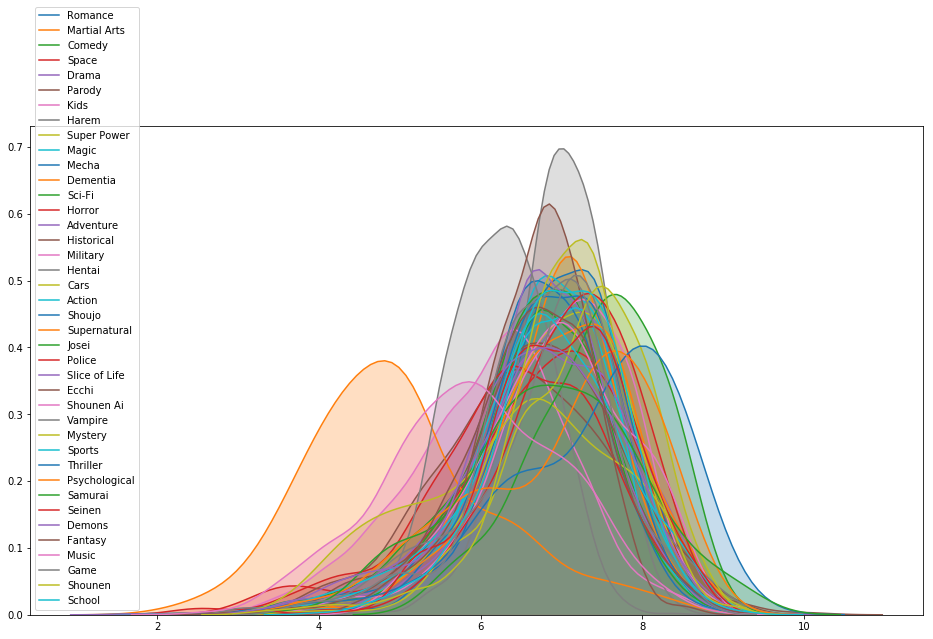

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
for g in genres:
    sns.kdeplot(anime[anime['genre'].str.contains(g)]['rating'], shade=True, label=g, ax=ax)

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

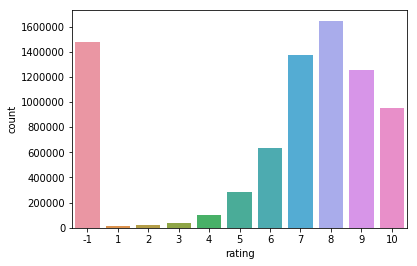

In [6]:
sns.countplot(data=ratings, x='rating')

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [24]:
user_ratings = ratings
user_ratings = user_ratings.set_index(["user_id", "anime_id"]).count(level="user_id")
user_ratings.columns = ['num_ratings']

anime_watches = ratings
anime_watches = anime_watches.set_index(["anime_id", "user_id"]).count(level="anime_id")
anime_watches.columns = ['num_watches']

anime_ratings = anime.join(anime_watches, on='anime_id')
anime_ratings = anime_ratings.merge(ratings.join(user_ratings, on='user_id').set_index('anime_id'), on='anime_id', how='left')

#=============================

anime_ratings = anime_ratings[(anime_ratings.num_ratings >= anime_ratings.num_ratings.median())]  
anime_ratings = anime_ratings[(anime_ratings.num_watches >= anime_ratings.num_watches.median())]
anime_ratings.loc[anime_ratings['rating_y'] == -1, 'rating_y'] = anime_ratings.loc[anime_ratings['rating_y'] == -1, 'rating_x']

#==============================

anime_ratings.drop(columns='rating_x')
anime_ratings.rename(columns={'rating_y':'rating'}, inplace=True)

anime_ratings

,name,genre,type,episodes,rating_x,members,num_watches,user_id,rating,num_ratings
anime_id,,,,,,,,,,
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,17.0,10.0,601.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,38.0,10.0,253.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,43.0,4.0,284.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,46.0,9.0,334.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,129.0,9.0,236.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,139.0,10.0,271.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,198.0,5.0,470.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,210.0,10.0,379.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0,226.0,6.0,742.0


In [21]:
anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960823 entries, 5114 to 17513
Data columns (total 10 columns):
name           object
genre          object
type           object
episodes       object
rating_x       float64
members        int64
num_watches    float64
user_id        float64
rating         float64
num_ratings    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 164.6+ MB


## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [ ]:
anime_ratings = anime_ratings.pivot(index='user_id', columns='name', values='rating')

anime_ratings.info()

In [29]:
anime_ratings = anime_ratings.fillna(0)
#anime_ratings

## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [33]:
pca = PCA(n_components=10)

anime_ratings3 = pca.fit_transform(anime_ratings)

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

CPU times: user 3.49 s, sys: 1.94 s, total: 5.43 s
Wall time: 3.11 s


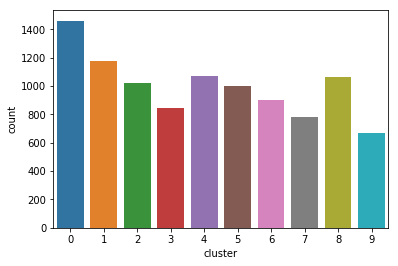

In [36]:
clusters_num = 10

learn_means = sklearn.cluster.KMeans(n_clusters = clusters_num)

%time index_anime = learn_means.fit_predict(anime_ratings3)
anime_ratings2 = anime_ratings

anime_ratings2['cluster'] = index_anime

sns.countplot(anime_ratings2['cluster'])

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [39]:
clusters = pd.DataFrame(columns=anime_ratings2.columns)

for i in range(clusters_num):
    clusters.loc[i] = anime_ratings2.loc[anime_ratings2['cluster'] == i].mean(skipna=True)

In [40]:
clusters = clusters.set_index(clusters['cluster'])
clusters_t = clusters.transpose()

for i in range(clusters_num):
    print(clusters_t[i].nlargest(15).to_string())

name
Death Note                            5.419863
Sen to Chihiro no Kamikakushi         5.186986
Fullmetal Alchemist                   5.064384
Code Geass: Hangyaku no Lelouch       4.870548
Mononoke Hime                         4.615753
Cowboy Bebop                          4.606849
Elfen Lied                            4.569178
Neon Genesis Evangelion               4.539041
Suzumiya Haruhi no Yuuutsu            4.419178
Howl no Ugoku Shiro                   4.377397
Code Geass: Hangyaku no Lelouch R2    4.211644
Tengen Toppa Gurren Lagann            4.157534
FLCL                                  3.968493
Akira                                 3.772603
Hellsing                              3.767123
name
No Game No Life                                             6.396771
Sword Art Online                                            6.344095
Shingeki no Kyojin                                          5.801189
Angel Beats!                                                5.672897
High Scho

## Top 5 жанров

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???